<h1 style="font-size:300%; font-family:monospace; background:#3CB371; color:white; text-align:center; border:10px solid ; padding:25px;"> Diabetes Prediction using Neural Networks</h1>

<h2 style="font-size:250%; font-family:monospace; color:#3CB371;"><b>What is diabetes?</b><h2>

<p style="font-size:80%; font-family:monospace">Diabetes mellitus, commonly known as diabetes, is a metabolic disease that causes high blood sugar. The hormone insulin moves sugar from the blood into your cells to be stored or used for energy. With diabetes, your body either doesn’t make enough insulin or can’t effectively use the insulin it does make.</p>
<p style="font-size:80%; font-family:monospace">So, the objective of this project is to  predict whether or not the patients in the dataset have diabetes</p>
<ul>   
    <li style="font-size:80%; font-family:monospace">The three main types of diabetes are: <b>type 1 diabetes, type 2 diabetes and gestational diabetes</b>.</li>
</ul>
    
<h2 style="font-size:250%; font-family:monospace; color:#3CB371;"><b>Dataset Information:</b><h2>    
<ul>
    <li style="font-size:80%; font-family:monospace"><b>Pregnancies:</b> Number of times pregnant</li>
    <li style="font-size:80%; font-family:monospace"><b>Glucose:</b> Plasma glucose concentration a 2 hours in an oral glucose tolerance test</li>
    <li style="font-size:80%; font-family:monospace"><b>Blood Pressure:</b>Diastolic blood pressure (mm Hg)</li>
    <li style="font-size:80%; font-family:monospace"><b>Skin Thickness:</b> Triceps skin fold thickness (mm)</li>
    <li style="font-size:80%; font-family:monospace"><b>Insulin:</b> 2-Hour Serum Insulin (mu U/ml)</li>
    <li style="font-size:80%; font-family:monospace"><b>BMI:</b> Body Mass Index (weight in kg/ height in m2)</li>
    <li style="font-size:80%; font-family:monospace"><b>Diabetes Pedigree Function:</b>  It provides information about diabetes history in relatives and genetic relationship of those relatives with patients. Higher Pedigree Function means patient is more likely to have diabetes.</li>
    <li style="font-size:80%; font-family:monospace"><b>Age:</b>Age (years)</li>
    <li style="font-size:80%; font-family:monospace"><b>Outcome:</b> Class Variable (0 or 1) where ‘0’ denotes patient not having diabetes and ‘1’ denotes patient having diabetes.</li>
</ul>


##### Before we begins, I would like to give credits to author of the dataset who has created [this notebook](https://www.kaggle.com/vincentlugat/pima-indians-diabetes-eda-prediction-0-906)

# 1. Data Exploration

<h4 style="font-size:150%; font-family:monospace; background:#3CB371; color:white; text-align:center; border:10px solid ; padding:25px;"> Import and Install Library </h4>

In [ ]:
!pip install adabelief-tf --upgrade -q

In [ ]:
import sys
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
%matplotlib inline

import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.figure_factory as ff
py.init_notebook_mode(connected=True)
from plotly.subplots import make_subplots
import plotly.express as px

from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.callbacks import EarlyStopping
from adabelief_tf import AdaBeliefOptimizer
from mlxtend.preprocessing import minmax_scaling 
import tensorflow as tf
from keras import backend as K
from sklearn.utils import class_weight

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv('../input/pima-indians-diabetes-database/diabetes.csv')

In [ ]:
df.sample(5)

In [ ]:
df.describe().T

In [ ]:
df.isnull().sum()

In [ ]:
def highlight_min(s):    
    is_max = s == s.min()
    return ['background-color: limegreen' if v else '' for v in is_max]
df.describe().T.style.apply(highlight_min, subset=['min'])

<div class="alert alert-block alert-info"> 📌 The highlighted value doesn't make sense and may indicates missing values except for the "Pregnancies" and "Outcome" features</div>

In [ ]:
df.info()

<h4 style="font-size:150%; font-family:monospace; background:#3CB371; color:white; text-align:center; border:10px solid ; padding:25px;"> Correlation Matrix </h4>

In [ ]:
fig_dims = (10, 8)
fig, ax = plt.subplots(figsize=fig_dims)
corrMatrix = df.corr()
sns.heatmap(corrMatrix, annot=True, ax=ax, cmap="Greens")

# 2. Data Cleaning

<h4 style="font-size:150%; font-family:monospace; background:#3CB371; color:white; text-align:center; border:10px solid ; padding:25px;"> Handling Missing Values </h4>

<div class="alert alert-block alert-info"> 📌 replace values 0 with np.NaN to plot graph</div>

In [ ]:
df[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']] = df[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']].replace(0,np.NaN)

In [ ]:
percent_missing = df.isnull().mean().round(4) * 100

In [ ]:
trace = go.Bar(x = percent_missing.index, y = percent_missing.values ,opacity = 0.8, text = percent_missing.values.round(4),  textposition = 'auto',marker=dict(color = '#90EE90',
        line=dict(color='#000000',width=1.25)))

layout = dict(title =  "Missing Values (count & %)")

fig = dict(data = [trace], layout=layout)
py.iplot(fig)

In [ ]:
col_with_null = ['Glucose', 'BloodPressure','SkinThickness','Insulin', 'BMI']

In [ ]:
sns.pairplot(df, hue="Outcome", palette="viridis")

<div class="alert alert-block alert-info"> 📌 We'll create functions to impute missing values with median since this dataset contains many outliers as we can see from the graph above</div>

<h4 style="font-size:150%; font-family:monospace; background:#3CB371; color:white; text-align:center; border:10px solid ; padding:25px;"> Impute Missing Values with Median </h4>

In [ ]:
def median_target(data, var):   
    temp = data[data[var].notnull()]
    temp = temp[[var, 'Outcome']].groupby(['Outcome'])[[var]].median().reset_index()
    return temp

In [ ]:
def replace_median(data, columns):
    for i in columns:
        f = median_target(data, i)
        display(f)
        data.loc[(data['Outcome'] == 0 ) & (data[i].isnull()), i] = f[[i]].values[0][0]
        data.loc[(data['Outcome'] == 1 ) & (data[i].isnull()), i] = f[[i]].values[1][0]

In [ ]:
replace_median(df, col_with_null)

In [ ]:
df.isnull().sum()

# 2.1 Feature Distribution

<h4 style="font-size:150%; font-family:monospace; background:#3CB371; color:white; text-align:center; border:10px solid ; padding:25px;"> Distribution of Each Feature w.r.t Label </h4>

In [ ]:
features = [i for i in df.columns]

<div class="alert alert-block alert-info"> 📌 create dataset that separate a person with and without diabetes to plot distribution where "D" represents diabetes and "H" represents Healthy. Then, create function to plot distribution and detect outliers</div>

In [ ]:
D = df[(df['Outcome'] != 0)]
H = df[(df['Outcome'] == 0)]

In [ ]:
def plot_distribution(data_select, size_bin) :  
    
    tmp1 = D[data_select]
    tmp2 = H[data_select]
    hist_data = [tmp1, tmp2]
    
    group_labels = ['diabetic', 'healthy']
    colors = ['#00FA9A', '#2F4F4F']

    fig = ff.create_distplot(hist_data, group_labels, colors = colors, show_hist = True, 
                             bin_size = size_bin, curve_type='kde')
    
    fig['layout'].update(title = data_select)

    py.iplot(fig)

In [ ]:
def plot_outliers(df, feat):
    
    trace0 = go.Box(
        y = df[feat],
        name = "All Points",
        jitter = 0.3,
        pointpos = -1.8,
        boxpoints = 'all',
        marker = dict(
            color = 'rgb(32,178,170)'),
        line = dict(
            color = 'rgb(32,178,170)')
    )

    trace1 = go.Box(
        y = df[feat],
        name = "Only Whiskers",
        boxpoints = False,
        marker = dict(
            color = 'rgb(0,128,128)'),
        line = dict(
            color = 'rgb(0,128,128)')
    )

    trace2 = go.Box(
        y = df[feat],
        name = "Suspected Outliers",
        boxpoints = 'suspectedoutliers',
        marker = dict(
            color = 'rgb(0,250,154)',
            outliercolor = '#FF69B4',
            line = dict(
                outliercolor = '#FF69B4',
                outlierwidth = 2)),
        line = dict(
            color = 'rgb(0,250,154)')
    )

    trace3 = go.Box(
        y = df[feat],
        name = "Whiskers and Outliers",
        boxpoints = 'outliers',
        marker = dict(
            color = 'rgb(47,79,79)'),
        line = dict(
            color = 'rgb(47,79,79)')
    )

    data = [trace0,trace1,trace2,trace3]

    layout = go.Layout(
        title = "{} Outliers".format(feat)
    )

    fig = go.Figure(data=data,layout=layout)
    py.iplot(fig)

In [ ]:
def plot_all_feature():
    for feat in features[:-1]:
        plot_distribution(feat, 0)
        plot_outliers(df, feat)
    plot_outliers(df, features[-1])

In [ ]:
plot_all_feature()

<h4 style="font-size:150%; font-family:monospace; background:#3CB371; color:white; text-align:center; border:10px solid ; padding:25px;"> Distribution of Two Features w.r.t Label </h4>

In [ ]:
def feat_distribution_corr(feat1, feat2):
    fig = px.density_contour(df, x=feat1, y=feat2, color="Outcome", 
                             marginal_y="rug", marginal_x="histogram",

                      title= f'{feat1} and {feat2}')
    fig.show()

In [ ]:
for i in range(len(features)):
    for z in range(i+1, len(features)):
        feat_distribution_corr(features[i], features[z])

<h4 style="font-size:150%; font-family:monospace; background:#3CB371; color:white; text-align:center; border:10px solid ; padding:25px;"> Handling Outliers </h4>

<li style="font-size:100%; font-family:monospace"><b></b>Inter Quartile Range approach to finding the outliers is the most commonly used and most trusted approach used in the research field. IQR = Q3-Q1</li>

<div class="alert alert-block alert-info"> 📌 To define the outlier base value which is defined above and below datasets's normal range: Upper and Lower bounds, define the upper and the lower bound (1.5*IQR value is considered)</div>

In [ ]:
def removeOutliers(df_out, feature, drop=False):

    valueOfFeature = df_out[feature]
    
    # Q1 (25th percentile) for the given feature
    Q1 = np.percentile(valueOfFeature, 25.)

    # Q3 (75th percentile) for the given feature
    Q3 = np.percentile(valueOfFeature, 75.)
    
    step = 1.5*(Q3-Q1)

    outliers = valueOfFeature[~((valueOfFeature >= Q1 - step) & (valueOfFeature <= Q3 + step))].index.tolist()
    feature_outliers = valueOfFeature[~((valueOfFeature >= Q1 - step) & (valueOfFeature <= Q3 + step))].values

    # Remove the outliers, if specified
    print ("Number of outliers (inc duplicates): {} and outliers: {}".format(len(outliers), feature_outliers))
    if drop:
        good_data = df_out.drop(df_out.index[outliers]).reset_index(drop = True)
        print ("New dataset with removed outliers has {} samples with {} features each.".format(*good_data.shape))
        return good_data
    else: 
        print ("Nothing happens, df.shape = ",df_out.shape)
        return df_out

In [ ]:
features

In [ ]:
df_clean = removeOutliers(df, features[0], True)
plot_outliers(df_clean, features[0])

In [ ]:
df_clean = removeOutliers(df_clean, features[1], True)
plot_outliers(df_clean, features[1])

In [ ]:
df_clean = removeOutliers(df_clean, features[2], True)
plot_outliers(df_clean, features[2])

In [ ]:
df_clean = removeOutliers(df_clean, features[3], True)
plot_outliers(df_clean, features[3])

In [ ]:
df_clean = removeOutliers(df_clean, features[4], True)
plot_outliers(df_clean, features[4])

In [ ]:
df_clean = removeOutliers(df_clean, features[5], True)
plot_outliers(df_clean, features[5])

In [ ]:
df_clean = removeOutliers(df_clean, features[6], True)
plot_outliers(df_clean, features[6])

In [ ]:
df_clean = removeOutliers(df_clean, features[7], True)
plot_outliers(df_clean, features[7])

In [ ]:
df_clean = removeOutliers(df_clean, features[8], True)
plot_outliers(df_clean, features[8])

In [ ]:
print('Original df.shape: {},-- New df.shape: {}, -- {} rows removed -- which is {}% of our data'.format(df.shape[0],df_clean.shape[0],
                                                              df.shape[0]-df_clean.shape[0],
                                                        (df.shape[0]-df_clean.shape[0])/df.shape[0]*100))

<div class="alert alert-block alert-info"> 📌 Check correlation once again</div>

In [ ]:
fig_dims = (10, 8)
fig, ax = plt.subplots(figsize=fig_dims)
corrMatrix = df_clean.corr()
sns.heatmap(corrMatrix, annot=True, ax=ax, cmap="Greens")

<h4 style="font-size:150%; font-family:monospace; background:#3CB371; color:white; text-align:center; border:10px solid ; padding:25px;"> Scaling the data for ANN model </h4>

In [ ]:
scaled_data = minmax_scaling(df_clean, columns=['Pregnancies','Glucose','BloodPressure',
                                           'SkinThickness','Insulin','BMI','DiabetesPedigreeFunction','Age'])

In [ ]:
scaled_data

# 3. Modeling

<h4 style="font-size:150%; font-family:monospace; background:#3CB371; color:white; text-align:center; border:10px solid ; padding:25px;"> Create Function for Model Evaluation </h4>

In [ ]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

<h4 style="font-size:150%; font-family:monospace; background:#3CB371; color:white; text-align:center; border:10px solid ; padding:25px;"> Create Function For Plotting </h4>

In [ ]:
def max_metric(history):
    max_acc = max(history.history['accuracy'])
    
    min_loss = min(history.history['loss'])
    max_val_acc = max(history.history['val_accuracy'])
    
    min_val_loss = min(history.history['val_loss'])
    print(f"Maximum Accuracy: {max_acc} \n Minimum Binary CrossEntropy Loss: {min_loss} \nMaximum Validation Accuracy: {max_val_acc} \nMaximum Validation Binary CrossEntropy Loss: {min_val_loss} \n")

In [ ]:
def plot_this(history):
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

<h4 style="font-size:150%; font-family:monospace; background:#3CB371; color:white; text-align:center; border:10px solid ; padding:25px;"> Build Model </h4>

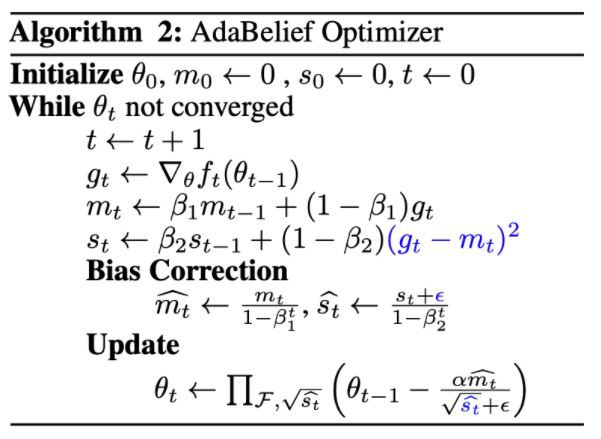

<li style="font-size:100%; font-family:monospace"><b>Three goals of AdaBelief:</b> Fast convergence as in adaptive methods, good generalization as in SGD, and training stability. The intuition for AdaBelief is to adapt the stepsize according to the "belief" in the current gradient direction. Viewing the exponential moving average (EMA) of the noisy gradient as the prediction of the gradient at the next time step, if the observed gradient greatly deviates from the prediction, we distrust the current observation and take a small step; if the observed gradient is close to the prediction, we trust it and take a large step.</li>

In [ ]:
def build_model():
    model = tf.keras.Sequential([
    tf.keras.layers.Dense(8, activation=tf.keras.layers.LeakyReLU(alpha=0.01), input_shape=[len(scaled_data.keys())]),
    tf.keras.layers.Dense(4, activation=tf.keras.layers.LeakyReLU(alpha=0.0125)),
    tf.keras.layers.Dense(1, activation='sigmoid')
  ])
    
    optimizer = AdaBeliefOptimizer(learning_rate=1e-3, epsilon=1e-7, rectify=False)
   
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy', f1_m, precision_m, recall_m])
    return model

model = build_model()

<div class="alert alert-block alert-info"> 📌 Here we can ignore the message, since we've updated the adabelief-tf already </div>

In [ ]:
model.summary()

<h4 style="font-size:150%; font-family:monospace; background:#3CB371; color:white; text-align:center; border:10px solid ; padding:25px;"> Class Weights Implementation for Imbalanced Data </h4>

In [ ]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(df_clean['Outcome']),
                                                 df_clean['Outcome'])

In [ ]:
class_weights

<h4 style="font-size:150%; font-family:monospace; background:#3CB371; color:white; text-align:center; border:10px solid ; padding:25px;"> Checkpoint, EarlyStopping, CSVLogger </h4>


<li style="font-size:100%; font-family:monospace"><b>checkpoint:</b> save model to a specific path base on val_accuracy.</li>
<li style="font-size:100%; font-family:monospace"><b>early_stopping:</b> stop the model training if val_loss is not decrease for > 200 epochs</li>
<li style="font-size:100%; font-family:monospace"><b>log_csv:</b> create and save model training history to csv file.</li>


In [ ]:
checkpoint_path = 'NN-{epoch:04d}.hdf5'
checkpoint_dir = os.path.dirname(checkpoint_path)
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', verbose=1,
    save_best_only=True, mode='max', period=1)
early_stopping = EarlyStopping(monitor ='val_loss', patience=200, verbose=1)
log_csv = CSVLogger('my_logs.csv', separator=',', append=False)
callbacks_list = [checkpoint, early_stopping, log_csv]

<h4 style="font-size:150%; font-family:monospace; background:#3CB371; color:white; text-align:center; border:10px solid ; padding:25px;"> Train Model </h4>

In [ ]:
history = model.fit(scaled_data, df_clean['Outcome'], validation_split=0.20, batch_size=32, 
          workers=-1, epochs=1000, verbose=2, class_weight={0:0.73484848, 1:1.56451613}, callbacks = callbacks_list)

<h4 style="font-size:150%; font-family:monospace; background:#3CB371; color:white; text-align:center; border:10px solid ; padding:25px;"> Model Evaluation </h4>

In [ ]:
max_metric(history)
plot_this(history)

# Reference
AdaBelief:

https://arxiv.org/abs/2010.07468

https://towardsdatascience.com/adabelief-optimizer-fast-as-adam-generalizes-as-good-as-sgd-71a919597af

Statistic: 

https://www.geeksforgeeks.org/detect-and-remove-the-outliers-using-python/

https://www.pluralsight.com/guides/cleaning-up-data-from-outliers

https://towardsdatascience.com/scale-standardize-or-normalize-with-scikit-learn-6ccc7d176a02

Notebook:

https://www.kaggle.com/pouryaayria/a-complete-ml-pipeline-tutorial-acu-86




<h1 style="font-size:300%; font-family:monospace; background:#3CB371; color:white; text-align:center; border:10px solid ; padding:25px;"> We've come to an end, kindly upvote if you found this helpful and I'll have motivation to keep posting more notebooks. Thanks for reading til the end.😊</h1>

<h1 style="font-size:200%; font-family:monospace; background:#3CB371; color:white; text-align:center; border:10px solid ; padding:25px;"> Any feedback and comments are welcome, I'll also be happy to review your notebook if I have time.  Happy Kaggling!</h1>